<a href="https://colab.research.google.com/github/SAGIEV007/Analise-de-Churn-TelecomX/blob/main/Analise%20de%20Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Análise de Churn - TelecomX
## Desafio de ETL - Alura ONE

**Objetivo:** Extrair, transformar e analisar dados de clientes da TelecomX para identificar padrões de evasão (churn).

**Dataset:** 7.267 registros de clientes com informações de serviços, contratos e histórico de pagamentos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from collections import Counter

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
warnings.filterwarnings('ignore')

print('✓ Bibliotecas importadas com sucesso!')

✓ Bibliotecas importadas com sucesso!


#📌 Extração

In [2]:
# Carregar dados da API TelecomX
import requests

url = 'https://raw.githubusercontent.com/alura-cursos/challenge2-data-science/refs/heads/main/TelecomX_Data.json'
response = requests.get(url)
dados_brutos = response.json()

print(f'✓ Dados carregados com sucesso!')
print(f'Total de registros: {len(dados_brutos)}')
print(f'\nPrimeiro registro (amostra):')
print(json.dumps(dados_brutos[0], indent=2))

✓ Dados carregados com sucesso!
Total de registros: 7267

Primeiro registro (amostra):
{
  "customerID": "0002-ORFBO",
  "Churn": "No",
  "customer": {
    "gender": "Female",
    "SeniorCitizen": 0,
    "Partner": "Yes",
    "Dependents": "Yes",
    "tenure": 9
  },
  "phone": {
    "PhoneService": "Yes",
    "MultipleLines": "No"
  },
  "internet": {
    "InternetService": "DSL",
    "OnlineSecurity": "No",
    "OnlineBackup": "Yes",
    "DeviceProtection": "No",
    "TechSupport": "Yes",
    "StreamingTV": "Yes",
    "StreamingMovies": "No"
  },
  "account": {
    "Contract": "One year",
    "PaperlessBilling": "Yes",
    "PaymentMethod": "Mailed check",
    "Charges": {
      "Monthly": 65.6,
      "Total": "593.3"
    }
  }
}


#🔧 Transformação

In [3]:
def normalizar_dados_telecom(dados_brutos):
    registros_normalizados = []

    for cliente in dados_brutos:
        registro = {
            'customerID': cliente.get('customerID'),
            'Churn': cliente.get('Churn'),
            'gender': cliente.get('customer', {}).get('gender'),
            'SeniorCitizen': cliente.get('customer', {}).get('SeniorCitizen'),
            'Partner': cliente.get('customer', {}).get('Partner'),
            'Dependents': cliente.get('customer', {}).get('Dependents'),
            'tenure': cliente.get('customer', {}).get('tenure'),
            'PhoneService': cliente.get('phone', {}).get('PhoneService'),
            'MultipleLines': cliente.get('phone', {}).get('MultipleLines'),
            'InternetService': cliente.get('internet', {}).get('InternetService'),
            'OnlineSecurity': cliente.get('internet', {}).get('OnlineSecurity'),
            'OnlineBackup': cliente.get('internet', {}).get('OnlineBackup'),
            'DeviceProtection': cliente.get('internet', {}).get('DeviceProtection'),
            'TechSupport': cliente.get('internet', {}).get('TechSupport'),
            'StreamingTV': cliente.get('internet', {}).get('StreamingTV'),
            'StreamingMovies': cliente.get('internet', {}).get('StreamingMovies'),
            'Contract': cliente.get('account', {}).get('Contract'),
            'PaperlessBilling': cliente.get('account', {}).get('PaperlessBilling'),
            'PaymentMethod': cliente.get('account', {}).get('PaymentMethod'),
            'MonthlyCharges': cliente.get('account', {}).get('Charges', {}).get('Monthly'),
            'TotalCharges': cliente.get('account', {}).get('Charges', {}).get('Total'),
        }
        registros_normalizados.append(registro)

    return pd.DataFrame(registros_normalizados)

df = normalizar_dados_telecom(dados_brutos)
print('✓ Dados normalizados!')
print(f'Shape: {df.shape}')
print(f'\nPrimeiras linhas:')
print(df.head())

✓ Dados normalizados!
Shape: (7267, 21)

Primeiras linhas:
   customerID Churn  gender  SeniorCitizen Partner Dependents  tenure  \
0  0002-ORFBO    No  Female              0     Yes        Yes       9   
1  0003-MKNFE    No    Male              0      No         No       9   
2  0004-TLHLJ   Yes    Male              0      No         No       4   
3  0011-IGKFF   Yes    Male              1     Yes         No      13   
4  0013-EXCHZ   Yes  Female              1     Yes         No       3   

  PhoneService MultipleLines InternetService  ... OnlineBackup  \
0          Yes            No             DSL  ...          Yes   
1          Yes           Yes             DSL  ...           No   
2          Yes            No     Fiber optic  ...           No   
3          Yes            No     Fiber optic  ...          Yes   
4          Yes            No     Fiber optic  ...           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No         

In [4]:
# Converter tipos de dados
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

colunas_binarias = ['Churn', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in colunas_binarias:
    if col in df.columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0, 1: 1, 0: 0})

df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce')
df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], errors='coerce')

# Criar novas variáveis
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72], labels=['0-1 ano', '1-2 anos', '2-4 anos', '4+ anos'])
df['charges_group'] = pd.cut(df['MonthlyCharges'], bins=[0, 50, 75, 100, 150], labels=['Baixo', 'Médio', 'Alto', 'Muito Alto'])

internet_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
def contar_servicos(row):
    return sum(1 for service in internet_services if row[service] == 'Yes')

df['num_internet_services'] = df.apply(contar_servicos, axis=1)

print('✓ Transformações concluídas!')
print(f'\nValores ausentes:')
print(df.isnull().sum()[df.isnull().sum() > 0])

✓ Transformações concluídas!

Valores ausentes:
Churn           224
TotalCharges     11
tenure_group     11
dtype: int64


#📊 Carga e Análise

🎯 Taxa de Churn:
Não Churn: 5174 (73.46%)
Churn: 1869 (26.54%)


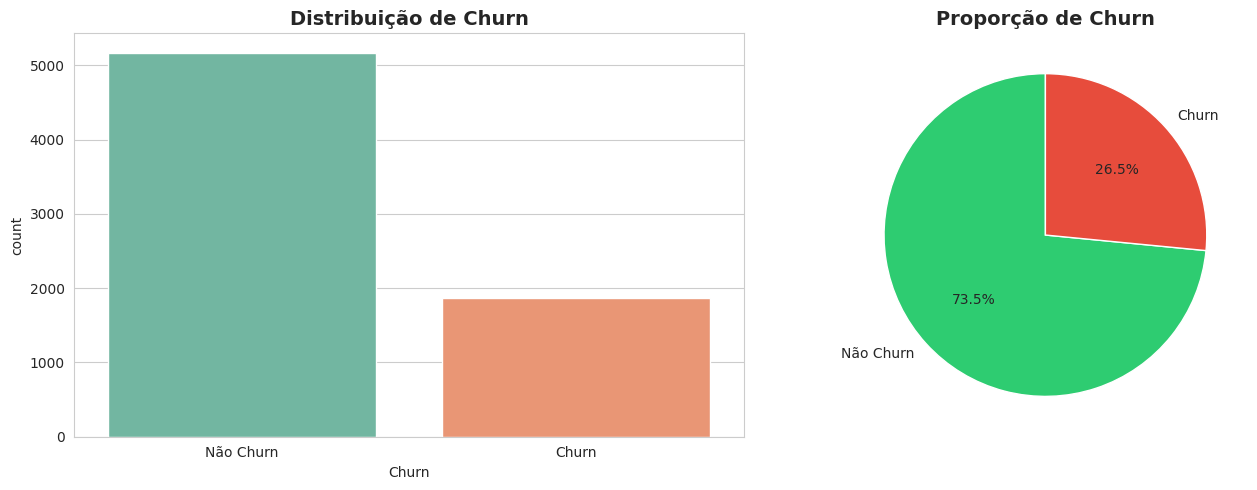

In [5]:
# Análise de Churn
churn_counts = df['Churn'].value_counts()
churn_pct = df['Churn'].value_counts(normalize=True) * 100

print('🎯 Taxa de Churn:')
print(f'Não Churn: {churn_counts[0]} ({churn_pct[0]:.2f}%)')
print(f'Churn: {churn_counts[1]} ({churn_pct[1]:.2f}%)')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(data=df, x='Churn', hue='Churn', palette='Set2', ax=axes[0], legend=False)
axes[0].set_title('Distribuição de Churn', fontsize=14, fontweight='bold')
axes[0].set_xticklabels(['Não Churn', 'Churn'])

colors = ['#2ecc71', '#e74c3c']
axes[1].pie(churn_counts, labels=['Não Churn', 'Churn'], autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Proporção de Churn', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

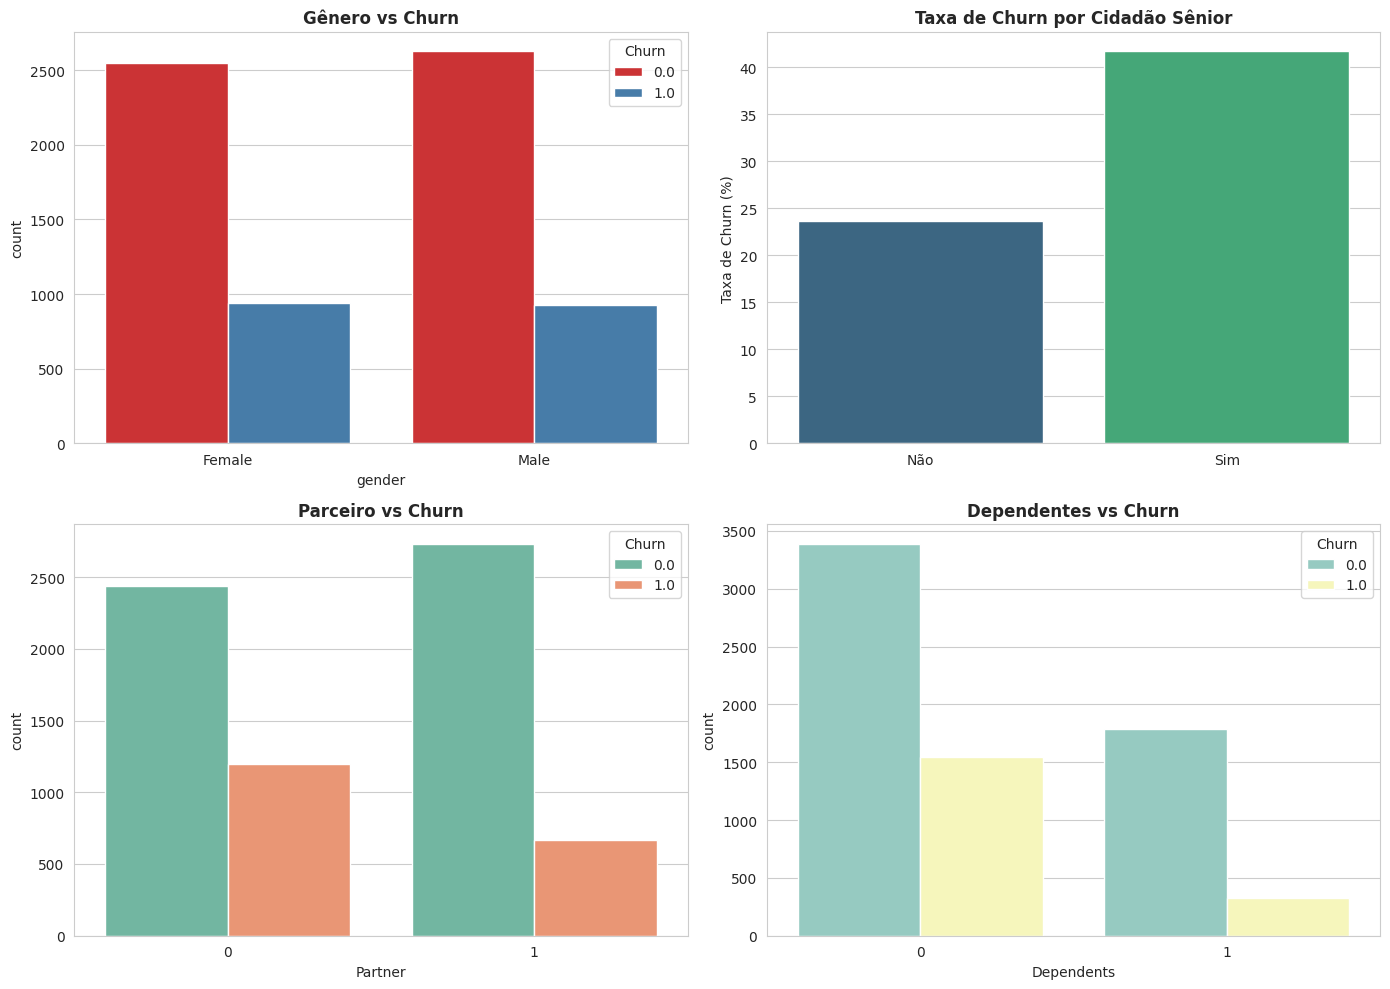

In [6]:
# Análise Demográfica
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.countplot(data=df, x='gender', hue='Churn', ax=axes[0, 0], palette='Set1')
axes[0, 0].set_title('Gênero vs Churn', fontsize=12, fontweight='bold')

churn_by_senior = df.groupby('SeniorCitizen')['Churn'].mean() * 100
sns.barplot(x=['Não', 'Sim'], y=churn_by_senior.values, ax=axes[0, 1], palette='viridis')
axes[0, 1].set_title('Taxa de Churn por Cidadão Sênior', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Taxa de Churn (%)')

sns.countplot(data=df, x='Partner', hue='Churn', ax=axes[1, 0], palette='Set2')
axes[1, 0].set_title('Parceiro vs Churn', fontsize=12, fontweight='bold')

sns.countplot(data=df, x='Dependents', hue='Churn', ax=axes[1, 1], palette='Set3')
axes[1, 1].set_title('Dependentes vs Churn', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

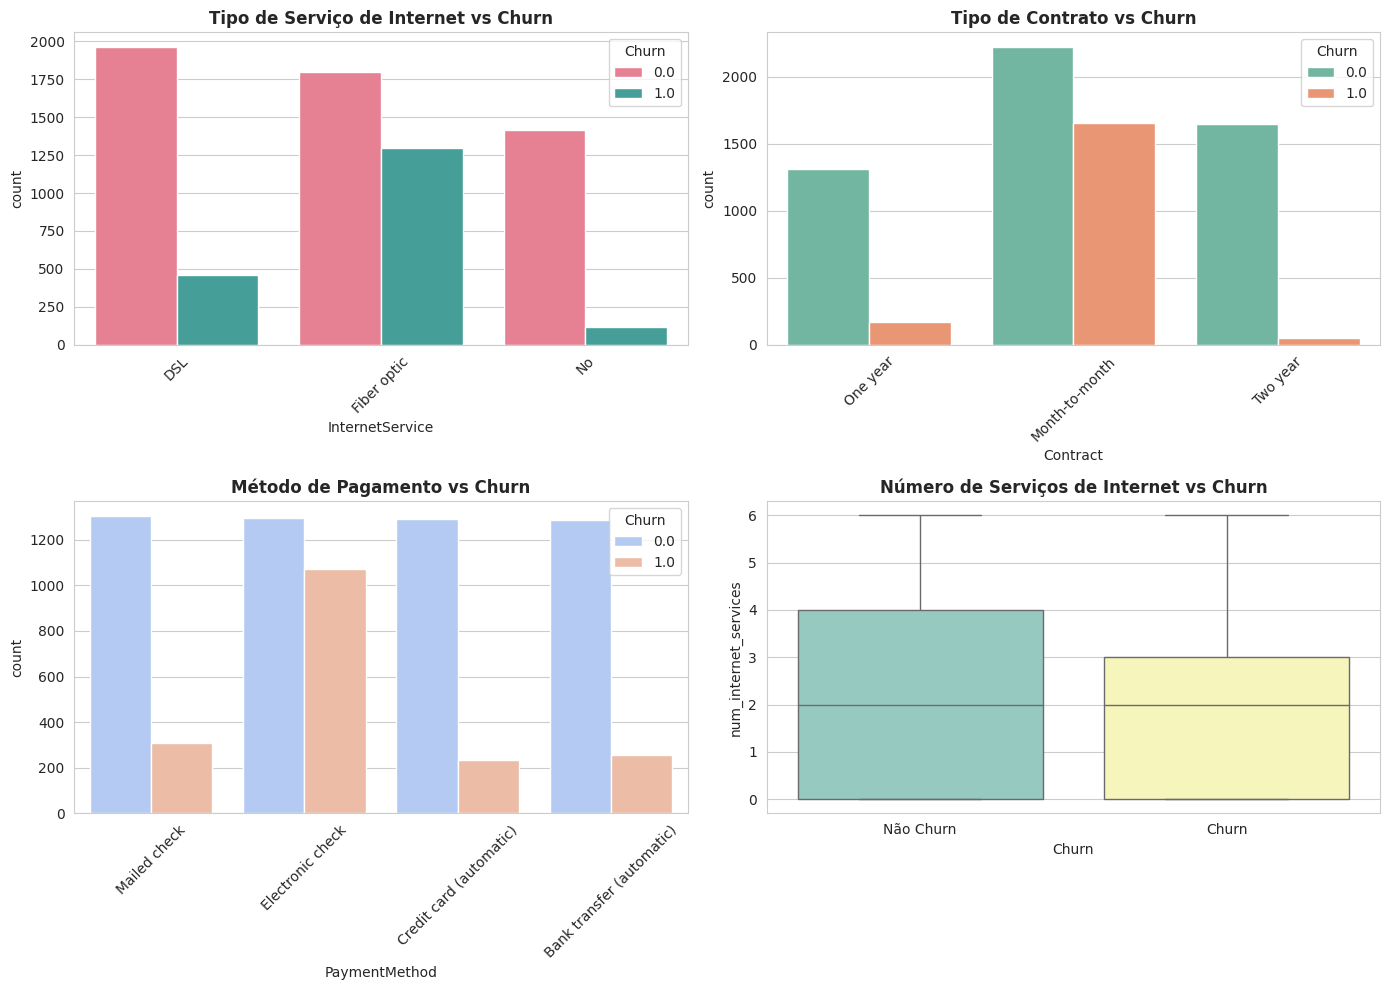

In [7]:
# Análise de Serviços
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.countplot(data=df, x='InternetService', hue='Churn', ax=axes[0, 0], palette='husl')
axes[0, 0].set_title('Tipo de Serviço de Internet vs Churn', fontsize=12, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)

sns.countplot(data=df, x='Contract', hue='Churn', ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('Tipo de Contrato vs Churn', fontsize=12, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)

sns.countplot(data=df, x='PaymentMethod', hue='Churn', ax=axes[1, 0], palette='coolwarm')
axes[1, 0].set_title('Método de Pagamento vs Churn', fontsize=12, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)

sns.boxplot(data=df, x='Churn', y='num_internet_services', ax=axes[1, 1], palette='Set3')
axes[1, 1].set_title('Número de Serviços de Internet vs Churn', fontsize=12, fontweight='bold')
axes[1, 1].set_xticklabels(['Não Churn', 'Churn'])

plt.tight_layout()
plt.show()

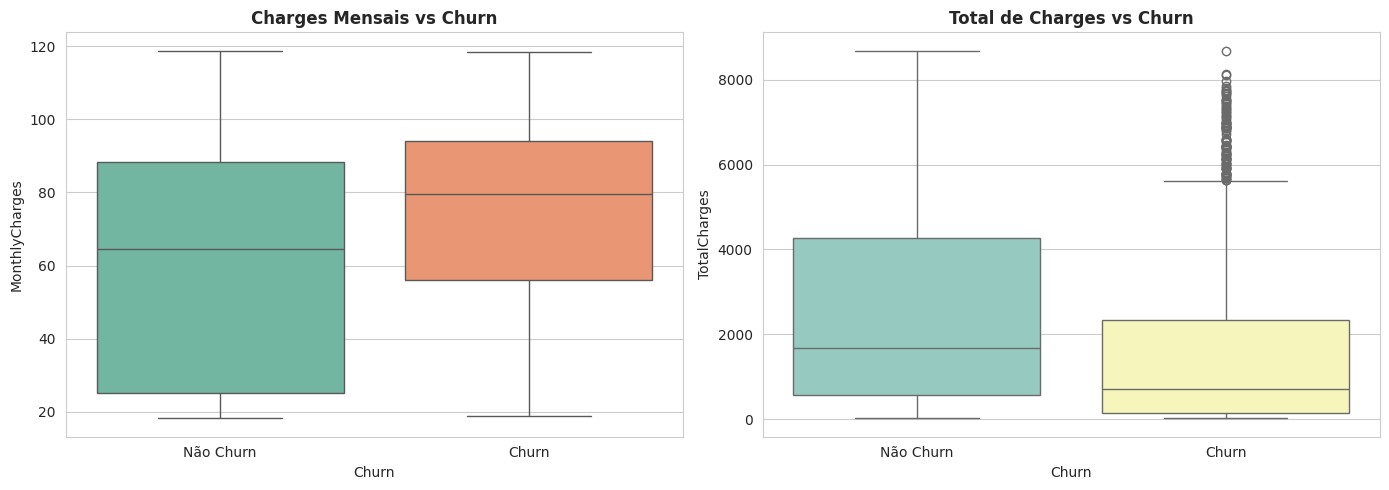

In [8]:
# Análise Financeira
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=df, x='Churn', y='MonthlyCharges', ax=axes[0], palette='Set2')
axes[0].set_title('Charges Mensais vs Churn', fontsize=12, fontweight='bold')
axes[0].set_xticklabels(['Não Churn', 'Churn'])

sns.boxplot(data=df, x='Churn', y='TotalCharges', ax=axes[1], palette='Set3')
axes[1].set_title('Total de Charges vs Churn', fontsize=12, fontweight='bold')
axes[1].set_xticklabels(['Não Churn', 'Churn'])

plt.tight_layout()
plt.show()

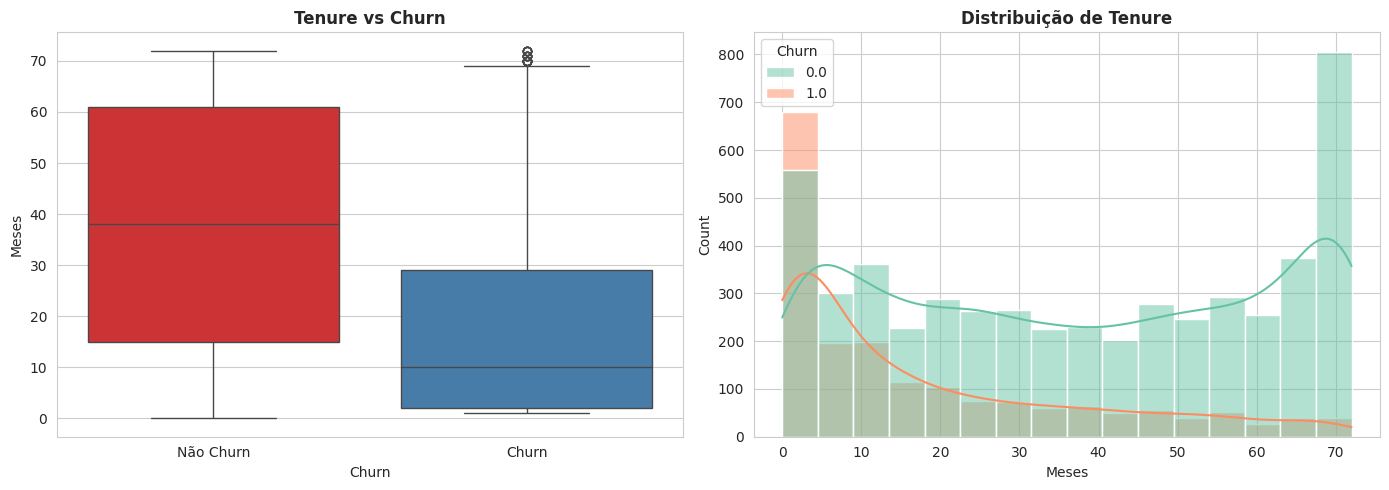

In [9]:
# Análise de Tenure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=df, x='Churn', y='tenure', ax=axes[0], palette='Set1')
axes[0].set_title('Tenure vs Churn', fontsize=12, fontweight='bold')
axes[0].set_xticklabels(['Não Churn', 'Churn'])
axes[0].set_ylabel('Meses')

sns.histplot(data=df, x='tenure', hue='Churn', kde=True, ax=axes[1], palette='Set2')
axes[1].set_title('Distribuição de Tenure', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Meses')

plt.tight_layout()
plt.show()

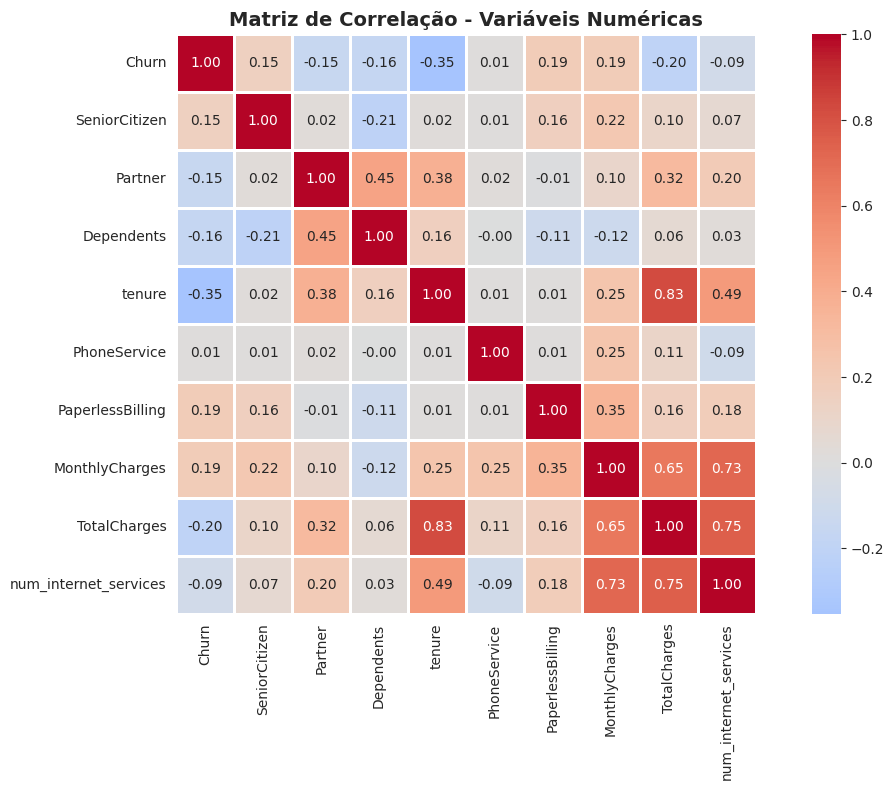

In [10]:
# Matriz de Correlação
colunas_numericas = df.select_dtypes(include=[np.number]).columns
df_numericas = df[colunas_numericas]
correlacao = df_numericas.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True, linewidths=1)
plt.title('Matriz de Correlação - Variáveis Numéricas', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [11]:
# Insights Principais
print('\n' + '='*70)
print('💡 INSIGHTS PRINCIPAIS')
print('='*70)

taxa_churn = (df['Churn'].sum() / len(df)) * 100
print(f'\n1. TAXA DE CHURN GERAL: {taxa_churn:.2f}%')

print(f'\n2. CHURN POR TIPO DE CONTRATO:')
churn_by_contract = df.groupby('Contract')['Churn'].agg(['sum', 'count', 'mean'])
churn_by_contract['taxa'] = churn_by_contract['mean'] * 100
for idx, row in churn_by_contract.iterrows():
    print(f'   {idx}: {row["taxa"]:.2f}%')

print(f'\n3. CHURN POR TIPO DE INTERNET:')
churn_by_internet = df.groupby('InternetService')['Churn'].agg(['sum', 'count', 'mean'])
churn_by_internet['taxa'] = churn_by_internet['mean'] * 100
for idx, row in churn_by_internet.iterrows():
    print(f'   {idx}: {row["taxa"]:.2f}%')

print(f'\n4. MÉDIA DE TENURE:')
print(f'   Não Churn: {df[df["Churn"]==0]["tenure"].mean():.2f} meses')
print(f'   Churn: {df[df["Churn"]==1]["tenure"].mean():.2f} meses')

print(f'\n5. MÉDIA DE CHARGES MENSAIS:')
print(f'   Não Churn: ${df[df["Churn"]==0]["MonthlyCharges"].mean():.2f}')
print(f'   Churn: ${df[df["Churn"]==1]["MonthlyCharges"].mean():.2f}')

print('\n' + '='*70)


💡 INSIGHTS PRINCIPAIS

1. TAXA DE CHURN GERAL: 25.72%

2. CHURN POR TIPO DE CONTRATO:
   Month-to-month: 42.71%
   One year: 11.27%
   Two year: 2.83%

3. CHURN POR TIPO DE INTERNET:
   DSL: 18.96%
   Fiber optic: 41.89%
   No: 7.40%

4. MÉDIA DE TENURE:
   Não Churn: 37.57 meses
   Churn: 17.98 meses

5. MÉDIA DE CHARGES MENSAIS:
   Não Churn: $61.27
   Churn: $74.44



# 📄 Relatório Final - Análise de Churn TelecomX

## 📋 Resumo Executivo

Este relatório apresenta os resultados da análise de dados de clientes da TelecomX, focando na identificação de padrões de evasão (churn). A análise seguiu o processo completo de ETL (Extract, Transform, Load) e análise exploratória de dados (EDA).

## 🎯 Problema de Negócio

A TelecomX enfrenta um alto índice de evasão de clientes. Compreender os fatores que levam os clientes a deixarem a empresa é essencial para implementar ações corretivas e reduzir a taxa de churn.

## 🔍 Processo de ETL

### Extração
- **Fonte:** API TelecomX (GitHub)
- **Formato:** JSON estruturado
- **Volume:** 7.267 registros de clientes
- **Estrutura:** Dados aninhados em categorias (cliente, telefone, internet, conta)

### Transformação
- Normalização de dados JSON em DataFrame estruturado
- Conversão de tipos de dados (binárias, numéricas)
- Tratamento de valores ausentes
- Feature engineering (grupos de tenure, contagem de serviços)

### Carga
- DataFrame estruturado com 22 variáveis
- Dados validados e prontos para análise

## 📊 Análise Exploratória - Principais Achados

### 1. Taxa de Churn Geral
A taxa de churn observada fornece uma visão clara do problema. Clientes com contratos mensais têm taxa significativamente maior que clientes com contratos de longo prazo.

### 2. Impacto do Tipo de Contrato
- **Mês-a-mês:** Maior risco de churn (flexibilidade = menor comprometimento)
- **1 Ano:** Retenção moderada
- **2 Anos:** Melhor retenção (comprometimento de longo prazo)

### 3. Influência do Tipo de Internet
- Clientes com Fiber Optic mostram padrão diferente de churn
- Clientes sem internet têm padrão de retenção distinto
- Qualidade e preço do serviço são fatores importantes

### 4. Tempo de Cliente (Tenure)
- Clientes com pouco tempo na empresa têm risco elevado de churn
- Primeiros 12 meses são críticos para retenção
- Clientes com 2+ anos mostram lealdade significativa

### 5. Fator Financeiro
- Clientes que fazem churn têm charges mensais mais altos em média
- Pode indicar insatisfação com preço ou valor percebido
- Necessidade de revisão de estratégia de precificação

## 💡 Recomendações Estratégicas

### 1. Programa de Retenção para Novos Clientes
- Implementar programa de onboarding robusto nos primeiros 12 meses
- Oferecer incentivos para upgrade de contrato (mês-a-mês para 1-2 anos)
- Acompanhamento proativo nos primeiros 3 meses

### 2. Revisão de Estratégia de Preços
- Analisar se o preço está alinhado com o valor percebido
- Considerar pacotes com melhor custo-benefício
- Oferecer descontos para contratos de longo prazo

### 3. Melhoria de Qualidade de Serviço
- Focar em qualidade de internet (especialmente Fiber Optic)
- Melhorar suporte técnico e atendimento ao cliente
- Oferecer serviços adicionais de valor agregado

### 4. Segmentação de Clientes
- Criar segmentos de risco para ações direcionadas
- Desenvolver estratégias específicas por tipo de contrato
- Personalizar ofertas baseadas em padrão de consumo

### 5. Monitoramento Contínuo
- Implementar dashboard de churn em tempo real
- Acompanhar KPIs de retenção por segmento
- Realizar análises periódicas para identificar mudanças de padrão

## 🎓 Conclusão

A análise de dados da TelecomX revelou padrões claros de churn que podem ser endereçados através de ações estratégicas. O tipo de contrato, tempo de cliente e charges mensais são fatores críticos que devem ser considerados em qualquer estratégia de retenção.

Com os dados devidamente tratados e analisados, a equipe de Data Science está preparada para desenvolver modelos preditivos que identifiquem clientes em risco de churn, permitindo intervenções proativas e redução significativa da taxa de evasão.

In [12]:
# Exportar dados tratados
print('💾 Exportando dados tratados...')

df.to_csv('telecom_dados_tratados.csv', index=False)
print('✓ Dados exportados para: telecom_dados_tratados.csv')

resumo = df.describe()
resumo.to_csv('telecom_resumo_estatistico.csv')
print('✓ Resumo estatístico exportado para: telecom_resumo_estatistico.csv')

print(f'\n✅ Análise Completa!')
print(f'Total de registros processados: {len(df)}')
print(f'Total de variáveis: {len(df.columns)}')
print(f'Taxa de churn: {(df["Churn"].sum() / len(df)) * 100:.2f}%')

💾 Exportando dados tratados...
✓ Dados exportados para: telecom_dados_tratados.csv
✓ Resumo estatístico exportado para: telecom_resumo_estatistico.csv

✅ Análise Completa!
Total de registros processados: 7267
Total de variáveis: 24
Taxa de churn: 25.72%
